# Remapping GOES ABI data

This notebook demonstrates how to use `pyresample` to remap GOES ABI data to another projection. While we are using GOES data, this process is generally applicable to any geolocated dataset. We will remap the GOES ABI data to the Multi-Radar Multi-Sensor CONUS domain, which uses a Plate Carree projeciton.

## Install Python packages

-  `s3fs` allows us to download data from the NOAA Open Data Dissemination Program ([NODD](https://www.noaa.gov/nodd/datasets#NESDIS))
-  [`pyresample`](https://pyresample.readthedocs.io/en/latest/) is a library that performs coordinate transformations for data.

This step might take 15-30 seconds.

In [1]:
!pip --quiet install s3fs
!pip --quiet install pyresample
!pip --quiet install cartopy
!pip --quiet install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.


## Import libraries

In [2]:
import xarray as xr
import s3fs
import pyresample
import datetime
import pyproj
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Download data

Here we download some ABI L1b data using `xarray` and `s3fs`. We are only downloading 10.3-µm data.

In [3]:
fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

abidt = datetime.datetime(2024,5,28,18,1)

file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')

## Convert to brightness temperature

In [4]:
ch13 = ds['Rad'][0].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]
planck_fk2 = ds['planck_fk2'].data[0]
planck_bc1 = ds['planck_bc1'].data[0]
planck_bc2 = ds['planck_bc2'].data[0]
ch13 = (planck_fk2 / (np.log((planck_fk1 / ch13) + 1)) - planck_bc1) / planck_bc2

## Look at the data

Let's take a look at the CONUS 10.3-µm data.

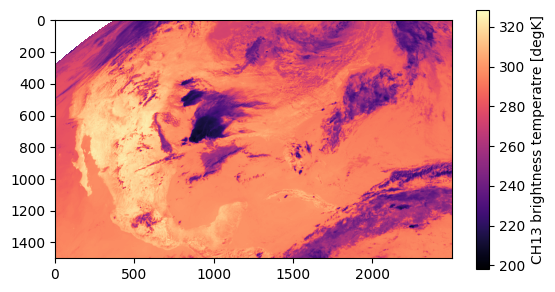

In [5]:
plt.imshow(ch13, cmap='magma')
plt.colorbar(label="CH13 brightness temperatre [degK]", shrink=0.7)
plt.show()

## Remap the data to MRMS projection

Great! The data look normal. But how do we transform it into a new projection? We use `pyresample`. There are two ways of handling this. We can use an `AreaDefinition` object, or a `GridDefinition` object. If you have the latitudes and longitudes at every point, then `GridDefinition` is probably easiest.

### `GridDefinition` method

This is how you convert the satellite's projection coordinates to latitudes and longitudes. See [here](https://proj.org/en/9.4/operations/projections/geos.html) for `geos` parameters. `x` and `y` are the "projection coordinates." `perspective_point_height` is the height of the satellite above the surface of the Earth (in meters), and `longitude_of_projection_origin` is the longitude that the satellite is at.

In [6]:
sat_height = ds.goes_imager_projection.perspective_point_height
sat_longitude = ds.goes_imager_projection.longitude_of_projection_origin
x = ds['x'].data * sat_height
y = ds['y'].data * sat_height

xx,yy = np.meshgrid(x,y)

projection = pyproj.Proj(f'+proj=geos +lon_0={sat_longitude} +h={sat_height}')

lons, lats = projection(xx, yy, inverse=True)


Now let's see how the `lats` and `lons` look.

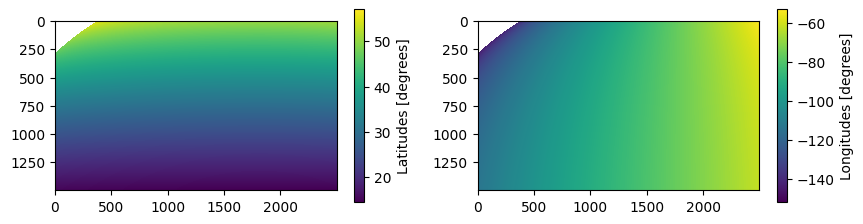

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
im1 = ax[0].imshow(lats)
fig.colorbar(im1, label='Latitudes [degrees]', shrink=0.5)
im2 = ax[1].imshow(lons)
fig.colorbar(im2,label='Longitudes [degrees]', shrink=0.5)
plt.show()

The coordinates look good to me. Now make the `GridDefinition` for the original projection.

In [8]:
goes_def = pyresample.geometry.GridDefinition(lats=lats, lons=lons)

Now we need the `GridDefinition` of the new projection. We are remapping to the [MRMS](https://www.nssl.noaa.gov/projects/mrms/) projection. I happen to know that the projection of MRMS is "cylindrical equidistant" or "equal-lat-lon."

- The Northwest corner point is `(55, -130)`
- There are 3500 latitudes and 7000 longitudes
- The resolution is 0.01 degree (approximately 1-km).

Let's make the MRMS lats and lons and the MRMS `GridDefinition`. But instead of using 0.01-degree resolution, we can use 0.02-degree resolution, because the IR data is at about 2-km.

In [9]:
tmp_lats = np.arange(55, 20, -0.02)
tmp_lons = np.arange(-130, -60, 0.02)
mrms_lons, mrms_lats = np.meshgrid(tmp_lons, tmp_lats)
mrms_def = pyresample.geometry.GridDefinition(lats=mrms_lats, lons=mrms_lons)

Now for the actual regridding / resampling!

We will be using `resample_nearest`, which uses nearest-neighbor to resample. You could also use `resample_gauss` if you want to weight nearby pixels.

`radius_of_influence` is in meters. Basically, how far around the point do you want the resampling algorithm to "look".

`fill_value` is the value to fill pixels where it couldn't resample (i.e., where original data is not in the new grid definition).

Remember that this should go much faster on a half-way decent server. On Colab, it takes 15-20 seconds.

In [10]:
remapped_goes = pyresample.kd_tree.resample_nearest(goes_def, ch13, mrms_def, radius_of_influence=4000, fill_value=0)

Finally, let's plot our old data and our new data in a georeferenced format, using `cartopy`.

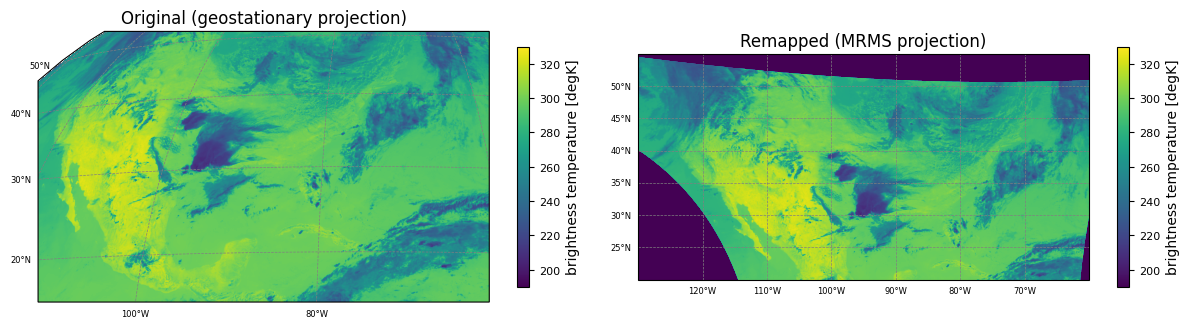

In [11]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(12, 6))

# Plot the unremapped data

crs = ccrs.Geostationary(central_longitude=sat_longitude)
extent = [x.min(), x.max(), y.min(), y.max()]
ax1 = fig.add_axes([0, 0, 0.47, 1], projection=crs)

orig = ax1.imshow(ch13, vmin=190, vmax=330, extent=extent, transform=crs)

gl = ax1.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar1 = fig.colorbar(orig,label='brightness temperature [degK]', shrink=0.4)
cbar1.ax.tick_params(labelsize=8)
ax1.set_title("Original (geostationary projection)")


# Plot the remaped data

crs_mrms = ccrs.PlateCarree()
extent = [-130, -60, 20, 55]
ax2 = fig.add_axes([0.50, 0, 0.47, 1], projection=crs_mrms)

remapped = ax2.imshow(remapped_goes, vmin=190, vmax=330, extent=extent, transform=crs_mrms)

gl2 = ax2.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl2.top_labels = None
gl2.right_labels = None
gl2.xlabel_style = {"size": 6}
gl2.ylabel_style = {"size": 6}

cbar2 = fig.colorbar(remapped,label='brightness temperature [degK]', shrink=0.4)
cbar2.ax.tick_params(labelsize=8)
ax2.set_title("Remapped (MRMS projection)")


plt.show()

### `AreaDefinition` method

The `AreaDefinition` method is very similar, but doesn't require the latitudes and longitudes. In only requires knowing the extent. Let's set up the `AreaDefinition` for the original and target projections. We could still use the `GridDefinition` for the MRMS projection if we wanted to. You can remap between `AreaDefinition`s and `GridDefinition`s interchangeably.

Note that the conversion of `x` and `y` by multipliying by `sat_height` still applies for the original projection.

In [12]:
ny, nx = ch13.shape

# Note that `area_extent` has the format: (lower_left_x, lower_left_y, upper_right_x, upper_right_y),
# which is different from the `extent` in `imshow` (lower_left_x, upper_right_x, lower_left_y, upper_right_y)

orig = pyresample.geometry.AreaDefinition('origProj', 'geosProj', 'projID1',
                                          ccrs.Geostationary(central_longitude=sat_longitude),
                                          width=nx,
                                          height=ny,
                                          area_extent=[x.min(), y.min(), x.max(), y.max()])

target = pyresample.geometry.AreaDefinition('foo', 'foo2', 'foo3',
                                          ccrs.PlateCarree(),
                                          width=len(tmp_lons),
                                          height=len(tmp_lats),
                                          area_extent=[-130, 20, -60, 55])

Remap the data. We could instead replace `target` with `mrms_def` from above.

In [13]:
remapped_goes_2 = pyresample.kd_tree.resample_nearest(orig, ch13, target, radius_of_influence=4000, fill_value=0)

And plot our original and remapped data.

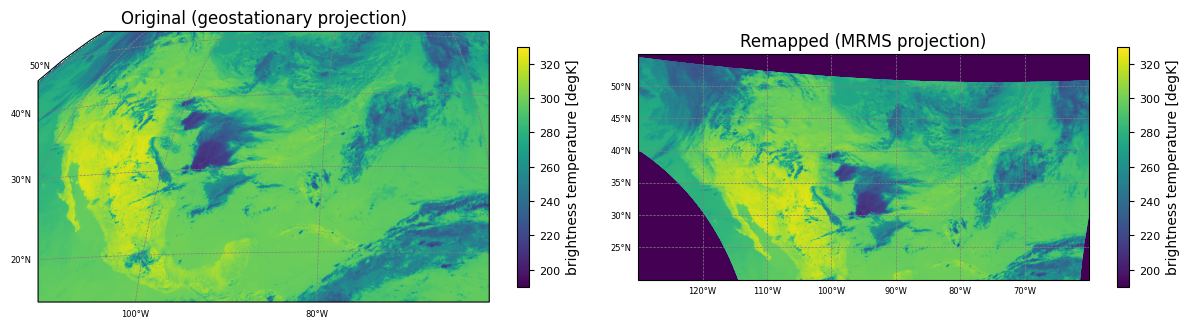

In [14]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(12, 6))

# Plot the unremapped data

crs = ccrs.Geostationary(central_longitude=sat_longitude)
extent = [x.min(), x.max(), y.min(), y.max()]
ax1 = fig.add_axes([0, 0, 0.47, 1], projection=crs)

orig = ax1.imshow(ch13, vmin=190, vmax=330, extent=extent, transform=crs)

gl = ax1.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar1 = fig.colorbar(orig,label='brightness temperature [degK]', shrink=0.4)
cbar1.ax.tick_params(labelsize=8)
ax1.set_title("Original (geostationary projection)")


# Plot the remaped data

crs_mrms = ccrs.PlateCarree()
extent = [-130, -60, 20, 55]
ax2 = fig.add_axes([0.50, 0, 0.47, 1], projection=crs_mrms)

remapped = ax2.imshow(remapped_goes_2, vmin=190, vmax=330, extent=extent, transform=crs_mrms)

gl2 = ax2.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl2.top_labels = None
gl2.right_labels = None
gl2.xlabel_style = {"size": 6}
gl2.ylabel_style = {"size": 6}

cbar2 = fig.colorbar(remapped,label='brightness temperature [degK]', shrink=0.4)
cbar2.ax.tick_params(labelsize=8)
ax2.set_title("Remapped (MRMS projection)")


plt.show()

The image from the cell above should match the cell from the `GridDefinition` method.

# Writing a WDSS2-compatible netCDF4

WDSS2 (www.wdssii.org) has some special requirements for its version of netCDF4 format:

-  Data must be in equal-lat equal-lon projection.
  -  This means `LatGridSpacing` and `LonGridSpacing` must be constants
-  There can only be one variable in each netCDF.
-  Required global attributes:
  - `TypeName` (should be the name of the variable)
  - `DataType` (usually `LatLonGrid`, if not using radar)
  - `LatGridSpacing`
  - `LonGridSpacing`
  - `Latitude` (NW  latitude)
  - `Longitude` (NW longitdue)
  - `Height`
  - `Time` (seconds since 1970-01-01 00:00:00 UTC)
  - `FractionalTime` (not sure if this is explicitly required)
  - `MissingData` (again, not sure if it's required, but it's a good idea to include)

## `write_netcdf` function

Let's write our remapped data in WDSS2 format. We'll use this `write_netcdf` function. Read the docstring for help.

In [15]:
import os
import netCDF4

def write_netcdf(output_file,
                 datasets,
                 dims,
                 atts={}):

  '''
  Parameters:
  -------------
  -  output_file (str): Full path to output filename
  -  datasets (dict): Nested set of dictionaries with top-level keys as variable names.
     -  structure:
        datasets[varname1] = {'data': numpy_ndarray_object,
                              'atts':{attname1: val1,   # these are variable attributes
                                      attname2: val2
                                     },
                              'dims': (dimYName, dimXName)}.    # the dimensions of datasets[varname1]['data']
  - dims (dict): Dictionary with string keys / integer values for the dimensions of every variable written to netCDF
  - atts (dict): Dictionary for global attributes

  Returns:
  -------------
  True if successful
  '''

  print('Process started')

  os.makedirs(os.path.dirname(output_file), exist_ok=True)
  ncfile = netCDF4.Dataset(output_file,'w') #,format='NETCDF3_CLASSIC')

  #dimensions
  for dim in dims:
    ncfile.createDimension(dim,dims[dim])
  #variables

  for varname in datasets:
    if(isinstance(datasets[varname]['data'],np.ndarray)):
      dtype = str((datasets[varname]['data']).dtype)
    elif(isinstance(datasets[varname]['data'],int) or isinstance(datasets[varname]['data'],np.int32) or isinstance(datasets[varname]['data'],np.int16)):
      dtype = 'i'
    elif(isinstance(datasets[varname]['data'],float) or isinstance(datasets[varname]['data'],np.float32) or isinstance(datasets[varname]['data'],np.float16)):
      dtype = 'f'

    if('_FillValue' in datasets[varname]['atts']):
      dat = ncfile.createVariable(varname,dtype,datasets[varname]['dims'],fill_value=datasets[varname]['atts']['_FillValue'])
    else:
      dat = ncfile.createVariable(varname,dtype,datasets[varname]['dims'])
    dat[:] = datasets[varname]['data']
    #variable attributes
    if('atts' in datasets[varname]):
      for att in datasets[varname]['atts']:
        if(att != '_FillValue'): dat.__setattr__(att,datasets[varname]['atts'][att]) #_FillValue is made in 'createVariable'
  #global attributes
  for key in atts:
    ncfile.__setattr__(key,atts[key])
  ncfile.close()
  print(f'Wrote out {output_file}')


  print('Process ended')

  return True

## `Dataset`, `Dims`, and `atts`

Now let's create/organize our input parameters. You can add addtional attributes if you would like. Also, please note that additional global attributes may be required to view in the WDSS2 GUI, `wg`, but I am not sure.

In [16]:
import collections

# Get timestamp
epoch_seconds = int((abidt - datetime.datetime(1970,1,1,0,0)).total_seconds())

remapped_ny, remapped_nx = remapped_goes.shape

dims = collections.OrderedDict()
dims['Lat'] = remapped_ny
dims['Lon'] = remapped_nx

varname = 'remapped_goes'
dataset = {varname:{'data':remapped_goes,
                    'dims':('Lat','Lon'),
                    'atts':{'units':'degK',
                            'missing_data': 0}}}
atts = collections.OrderedDict()
atts['TypeName'] = varname
atts['DataType'] = 'LatLonGrid'
atts['LatGridSpacing'] = 0.02   # we created the MRMS projection at 0.02-degree resolution
atts['LonGridSpacing'] = 0.02   # we created the MRMS projection at 0.02-degree resolution
atts['Latitude'] = 55
atts['Longitude'] = -130
atts['Height'] = 0.             # I believe this is usually ignored unless you are dealing with tilts
atts['Time'] = epoch_seconds
atts['FractionalTime'] = 0.
atts['MissingData'] = 0
atts['attributes'] = ""

## Write out the netCDF

And write the netCDF. The name of the netCDF must be a timestamp, in format: `'%Y%m%d-%H%M%S.netcdf'`, and it should be in a directory that is named `varname`.

In [17]:
outnc = abidt.strftime(f'outnc/{varname}/%Y%m%d-%H%M%S.netcdf')

write_netcdf(outnc, dataset, dims, atts=atts)

Process started
Wrote out outnc/remapped_goes/20240528-180100.netcdf
Process ended


True

## Inspect the output

Now let's look at the netCDF.

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    TypeName: remapped_goes
    DataType: LatLonGrid
    LatGridSpacing: 0.02
    LonGridSpacing: 0.02
    Latitude: 55
    Longitude: -130
    Height: 0.0
    Time: 1716919260
    FractionalTime: 0.0
    MissingData: 0
    attributes: 
    dimensions(sizes): Lat(1750), Lon(3500)
    variables(dimensions): float32 remapped_goes(Lat, Lon)
    groups: 


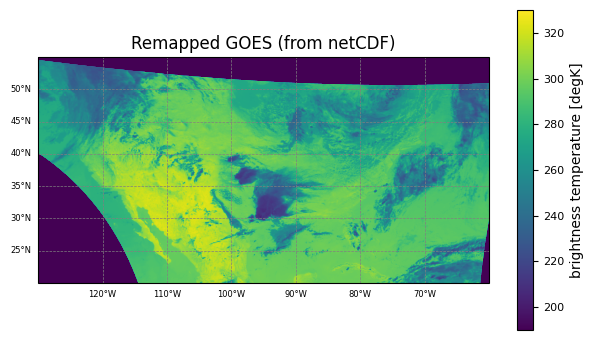

In [18]:
nc = netCDF4.Dataset('outnc/remapped_goes/20240528-180100.netcdf')
print(nc)
data = nc.variables['remapped_goes'][:]
nc.close()

crs_mrms = ccrs.PlateCarree()
extent = [-130, -60, 20, 55]

fig = plt.figure(figsize=(12, 8))

ax = fig.add_axes([0.50, 0, 0.47, 1], projection=crs_mrms)

remapped = ax.imshow(data, vmin=190, vmax=330, extent=extent, transform=crs_mrms)

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle="--",
)
# Customize the gridline labels
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar = fig.colorbar(remapped,label='brightness temperature [degK]', shrink=0.4)
cbar.ax.tick_params(labelsize=8)
ax.set_title("Remapped GOES (from netCDF)")

plt.show()

Looks good to me! This netCDF should now work in WDSS2 algorithms such as `w2segmotionll`, `w2cropconv`, etc.